# HDA Project Speech Recognition

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend
from tensorflow.keras.utils import audio_dataset_from_directory
import matplotlib.pyplot as plt

#### Loading and Preprocessing the Data

In [2]:
df_train, df_val = audio_dataset_from_directory(directory='speech_commands_v0.02/', 
                                                labels='inferred', 
                                                label_mode='int', 
                                                batch_size=16, 
                                                validation_split=0.2, 
                                                subset='both', 
                                                seed=0)
labels = np.array(df_train.class_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.
Metal device set to: Apple M1


2023-01-09 18:51:18.112539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-09 18:51:18.112941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def squeeze_samples(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

df_train = df_train.map(squeeze_samples, tf.data.AUTOTUNE)
df_val = df_val.map(squeeze_samples, tf.data.AUTOTUNE)

In [4]:
df_test = df_val.shard(num_shards=2, index=0)
df_val = df_val.shard(num_shards=2, index=1)

(16, 16000)
(16,)


2023-01-09 18:51:18.301168: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


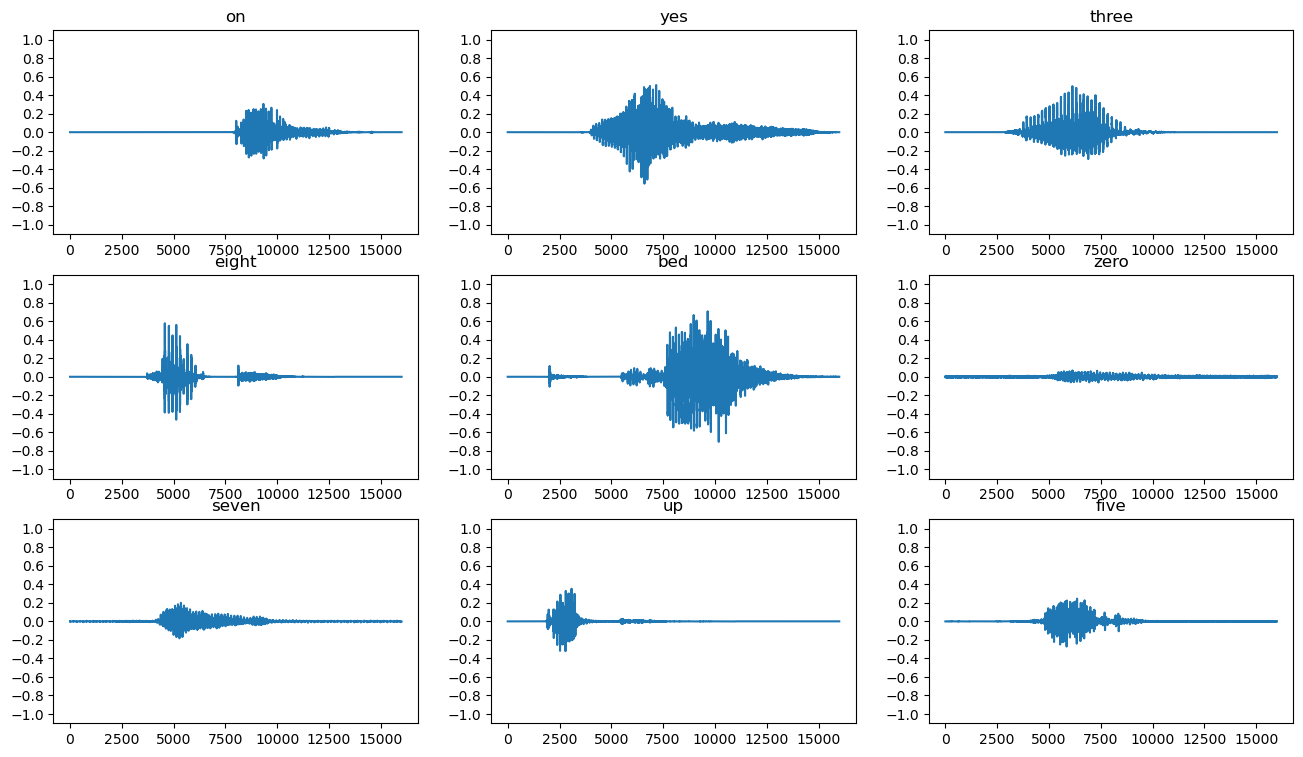

In [5]:
for example_audio, example_label in df_train.take(1):
    print(example_audio.shape)
    print(example_label.shape)

row = 3
cols = 3
n = row * cols
fig, axes = plt.subplots(row, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = labels[example_label[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

In [9]:
def get_spectrogram(waveform, frame_length=550, frame_step=128, mel=True):
    
    spectrogram = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0.0, 3000.0, 120
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=num_mel_bins, 
                                                       num_spectrogram_bins=num_spectrogram_bins, 
                                                       sample_rate=16000, 
                                                       lower_edge_hertz=lower_edge_hertz, 
                                                       upper_edge_hertz=upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, mel_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(mel_matrix.shape[-1:]))
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    if mel:
        return mel_spectrogram[...,tf.newaxis]
    return np.log(spectrogram.numpy().T + np.finfo(float).eps)[..., tf.newaxis]

In [10]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    height = spectrogram.shape[0]
    width = spectrogram.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, spectrogram)

In [11]:
waveform = example_audio[1]
spectrogram = get_spectrogram(example_audio[0], mel=False)
spectrogram1 = get_spectrogram(example_audio[0])

In [12]:
print(spectrogram.shape, 
      spectrogram1.shape)

(513, 121, 1) (121, 120, 1)


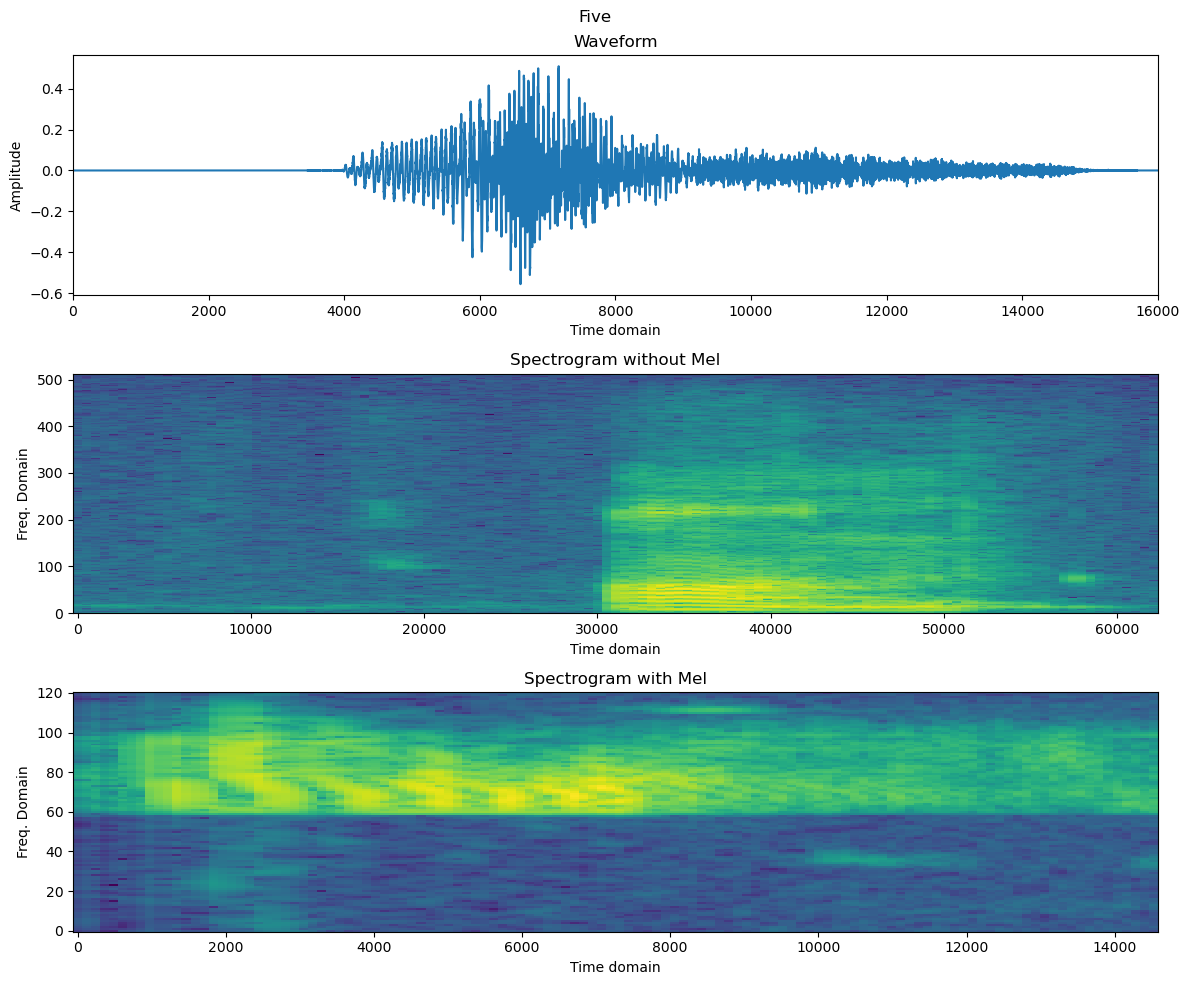

In [13]:
fig, axes = plt.subplots(3, figsize=(12, 10))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
axes[0].set_xlabel('Time domain')
axes[0].set_ylabel('Amplitude')
#axes[1].set_xlim([0, 16000])
axes[1].set_xlabel('Time domain')
axes[1].set_ylabel('Freq. Domain')
axes[2].set_xlabel('Time domain')
axes[2].set_ylabel('Freq. Domain')


plot_spectrogram(spectrogram, axes[1])
plot_spectrogram(spectrogram1, axes[2])
axes[1].set_title('Spectrogram without Mel')
axes[2].set_title('Spectrogram with Mel')
plt.suptitle(label.title())
fig.tight_layout()
plt.show()

In [14]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
train_spectrogram_ds = make_spec_ds(df_train)
val_spectrogram_ds = make_spec_ds(df_val)
test_spectrogram_ds = make_spec_ds(df_test)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

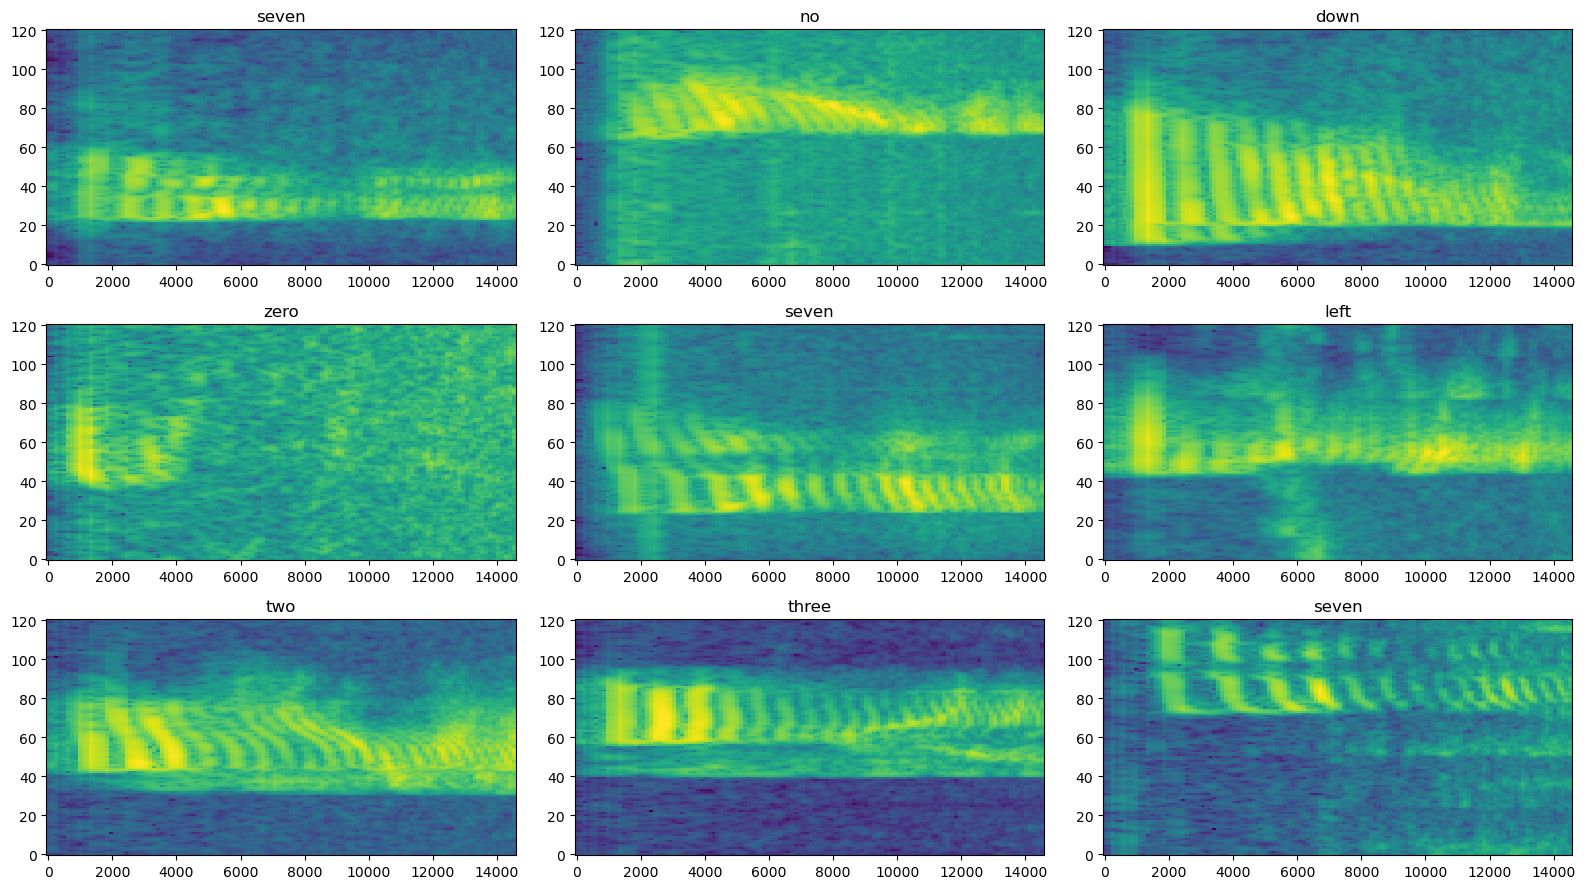

In [17]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i], ax)
    ax.set_title(labels[example_spect_labels[i].numpy()])

fig.tight_layout()
plt.show()

In [58]:
def squeeze_audio(x):
    x = tf.squeeze(x, axis=0)
    return x

In [90]:
samplingRate=16000
input_shape = example_spectrograms.shape[1:]
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.take(1).map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    #Normalize.
    
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    #layers.Lambda(squeeze_audio, name='squeeze_last_dim'),
    #layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    #layers.Bidirectional(layers.LSTM(64)),
    
    layers.ConvLSTM1D(10, 3, return_sequences=True),
    layers.ConvLSTM1D(5, 1),
    
    
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='relu')
    ])

model.summary()

2023-01-09 19:59:38.480098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-09 19:59:38.508870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_25 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_33 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 batch_normalization_44 (Bat  (None, 30, 30, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_56 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_45 (Bat  (None, 28, 28, 64)     

In [91]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [92]:
EPOCHS = 10
history = model.fit(
    test_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2023-01-09 19:59:47.012364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


662/662 [==============================] - ETA: 0s - loss: 3.4592 - accuracy: 0.0981

2023-01-09 20:13:35.969469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


662/662 [==============================] - 882s 1s/step - loss: 3.4592 - accuracy: 0.0981 - val_loss: 3.0496 - val_accuracy: 0.2758
Epoch 2/10
662/662 [==============================] - 943s 1s/step - loss: 2.7587 - accuracy: 0.3270 - val_loss: 2.4384 - val_accuracy: 0.4141
Epoch 3/10
662/662 [==============================] - 1130s 2s/step - loss: 2.3636 - accuracy: 0.4270 - val_loss: 2.2993 - val_accuracy: 0.4457
Epoch 4/10
662/662 [==============================] - 1982s 3s/step - loss: 2.1513 - accuracy: 0.4817 - val_loss: 2.2838 - val_accuracy: 0.4468
Epoch 5/10
662/662 [==============================] - 1571s 2s/step - loss: 2.0198 - accuracy: 0.5121 - val_loss: 2.1240 - val_accuracy: 0.4804
Epoch 6/10
662/662 [==============================] - 908s 1s/step - loss: 1.9135 - accuracy: 0.5369 - val_loss: 1.9952 - val_accuracy: 0.5113
Epoch 7/10
662/662 [==============================] - 949s 1s/step - loss: 1.8266 - accuracy: 0.5530 - val_loss: 2.0399 - val_accuracy: 0.5022
Epoch 8

Text(0, 0.5, 'Accuracy [%]')

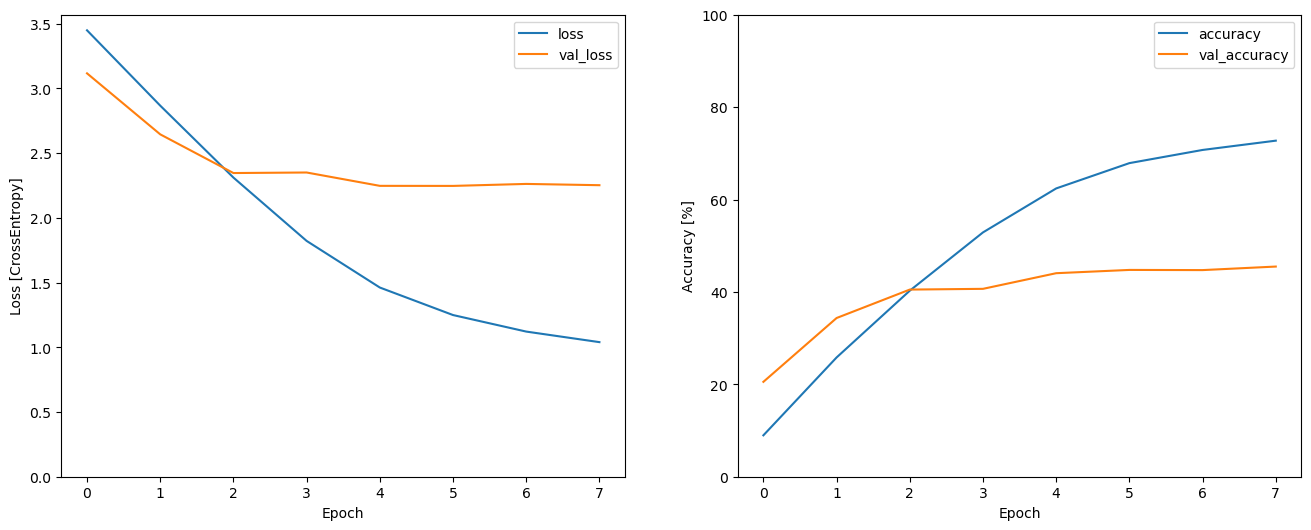

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')